/root/miniconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/llm/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/root/miniconda3/envs/llm/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for fashion_mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content

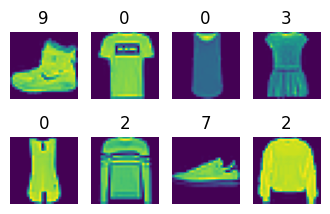

In [1]:
from datasets import load_dataset

from utils.utils import show_images

fashion_mnist = load_dataset("fashion_mnist")
clothes = fashion_mnist["train"]["image"][:8]
classes = fashion_mnist["train"]["label"][:8]
show_images(clothes, titles=classes, figsize=(4, 2.5))

In [2]:
import torch
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Pad(2),  # Add 2 pixels on all sides
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image) for image in examples["image"]]
    return {"images": images, "labels": examples["label"]}


train_dataset = fashion_mnist["train"].with_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True
)

In [3]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=1,  # 1 channel for grayscale images
    out_channels=1,
    sample_size=32,
    block_out_channels=(32, 64, 128, 256),
    num_class_embeds=10,  # Enable class conditioning
)

In [4]:
x = torch.randn((1, 1, 32, 32))
with torch.no_grad():
    out = model(x, timestep=7, class_labels=torch.tensor([2])).sample
out.shape

torch.Size([1, 1, 32, 32])

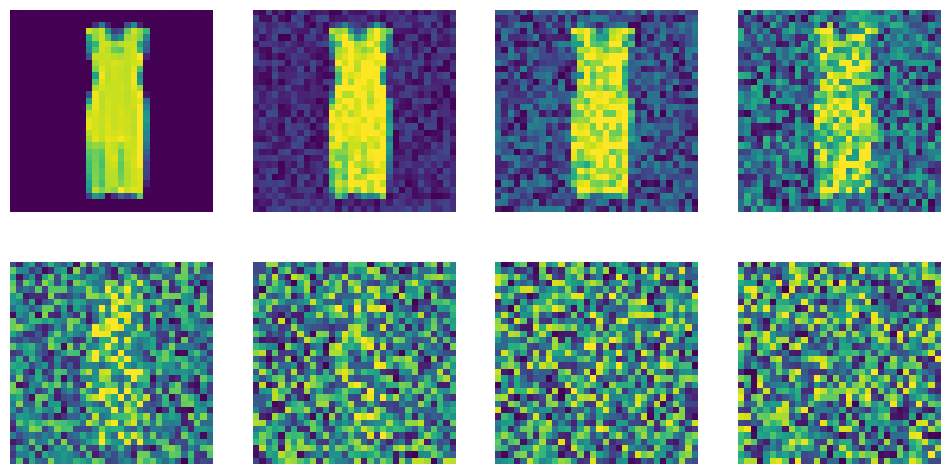

In [5]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02
)
timesteps = torch.linspace(0, 999, 8).long()
batch = next(iter(train_dataloader))
x = batch["images"][0].expand([8, 1, 32, 32])
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [9]:
from torch.nn import functional as F
from tqdm import tqdm

scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02
)

num_epochs = 25
lr = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
losses = []  # Somewhere to store the loss values for later plotting

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Train the model (this takes a while!)
for epoch in (progress := tqdm(range(num_epochs))):
    for step, batch in (
        inner := tqdm(
            enumerate(train_dataloader),
            position=0,
            leave=True,
            total=len(train_dataloader),
        )
    ):
        # Load the input images and classes
        clean_images = batch["images"].to(device)
        class_labels = batch["labels"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # Add noise to the clean images according to the timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise - note the use of class_labels
        noise_pred = model(
            noisy_images,
            timesteps,
            class_labels=class_labels,
            return_dict=False,
        )[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(noise_pred, noise)

        # Display loss
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")

        # Store the loss for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 25/25 [10:25<00:00, 25.03s/it]


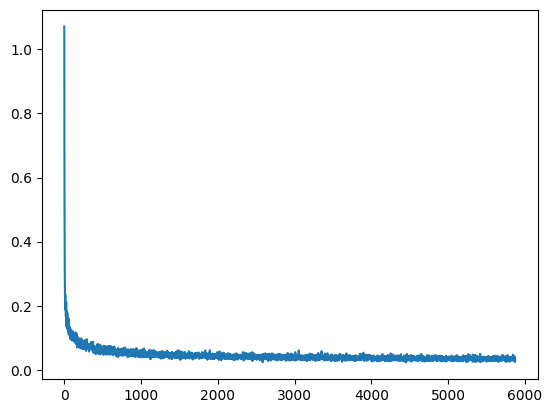

In [10]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [11]:
def generate_from_class(class_to_generate, n_samples=8):
    sample = torch.randn(n_samples, 1, 32, 32).to(device)
    class_labels = [class_to_generate] * n_samples
    class_labels = torch.tensor(class_labels).to(device)

    for _, t in tqdm(enumerate(scheduler.timesteps)):
        # Get model pred
        with torch.no_grad():
            noise_pred = model(sample, t, class_labels=class_labels).sample

        # Update sample with step
        sample = scheduler.step(noise_pred, t, sample).prev_sample

    return sample.clip(-1, 1) * 0.5 + 0.5

1000it [00:11, 85.64it/s]


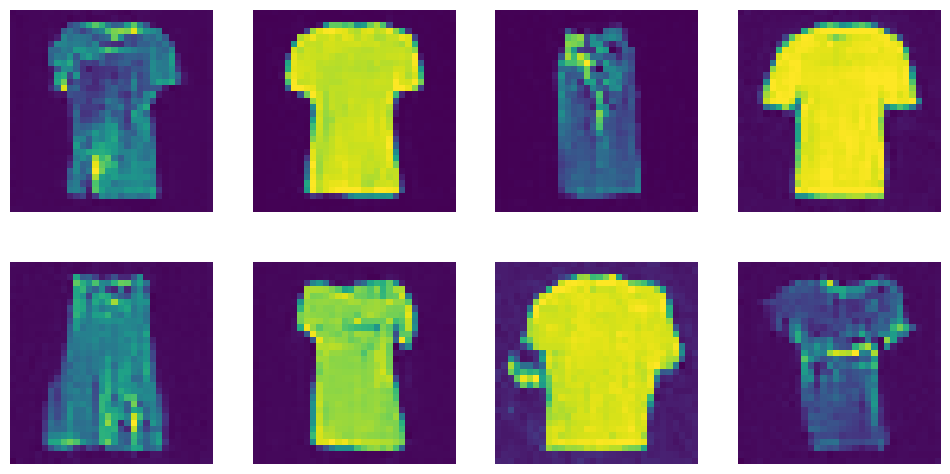

In [12]:
# Generate t-shirts (class 0)
images = generate_from_class(0)
show_images(images, nrows=2)

1000it [00:11, 83.86it/s]


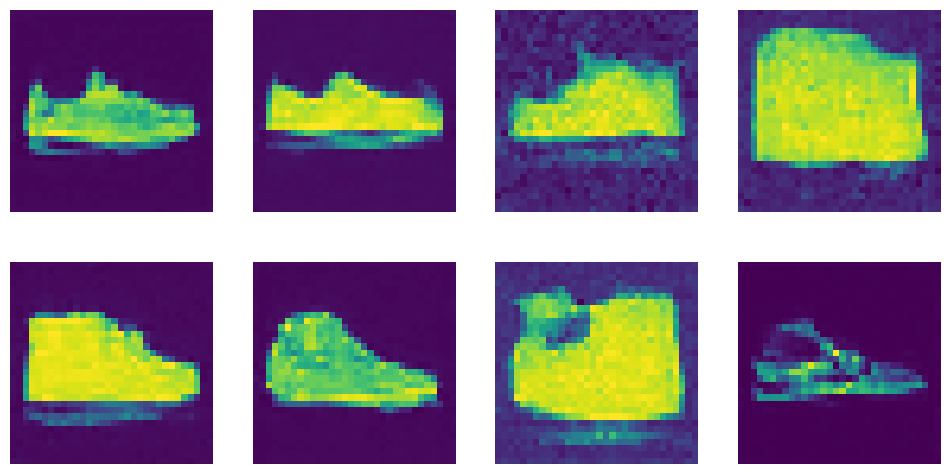

In [13]:
# Now generate some sneakers (class 7)
images = generate_from_class(7)
show_images(images, nrows=2)

1000it [00:11, 83.81it/s]


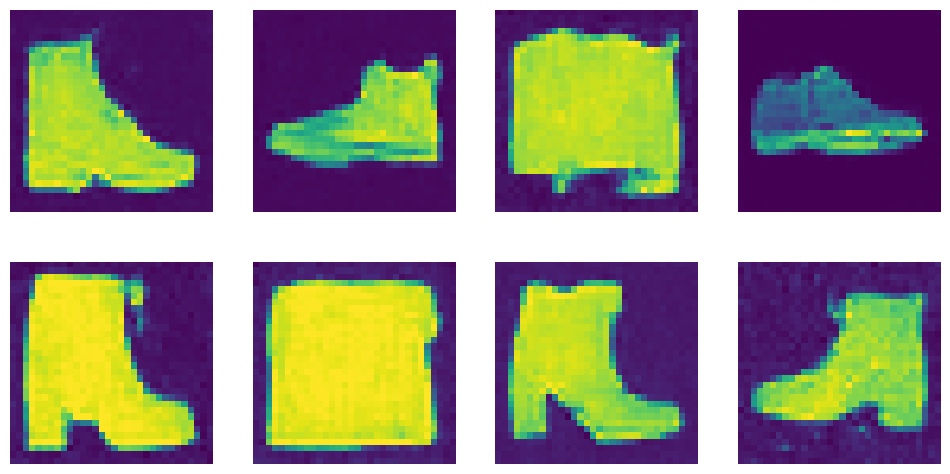

In [14]:
# ...or boots (class 9)
images = generate_from_class(9)
show_images(images, nrows=2)

In [15]:
from diffusers import AutoencoderKL, StableDiffusionPipeline

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16
).to(device)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


100%|██████████| 50/50 [00:01<00:00, 29.71it/s]


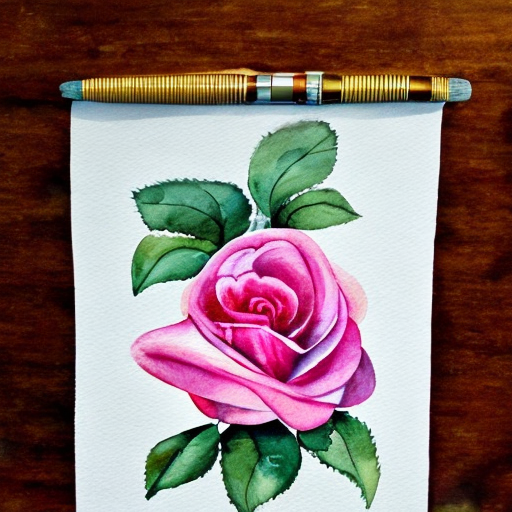

In [16]:
pipe("Watercolor illustration of a rose").images[0]

In [17]:
prompt = "A photograph of a puppy"

# Turn the text into a sequence of tokens:
text_input = pipe.tokenizer(
    prompt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

# See the individual tokens
for t in text_input["input_ids"][0][:8]:  # We'll just look at the first 7
    print(t, pipe.tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(8853) photograph</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [18]:
text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
print("Text embeddings shape:", text_embeddings.shape)

Text embeddings shape: torch.Size([1, 77, 768])


In [19]:
images = []
prompt = "An oil painting of a collie in a top hat"
for guidance_scale in [1, 2, 4, 12]:
    torch.manual_seed(0)
    image = pipe(prompt, guidance_scale=guidance_scale).images[0]
    images.append(image)

100%|██████████| 50/50 [00:01<00:00, 37.01it/s]


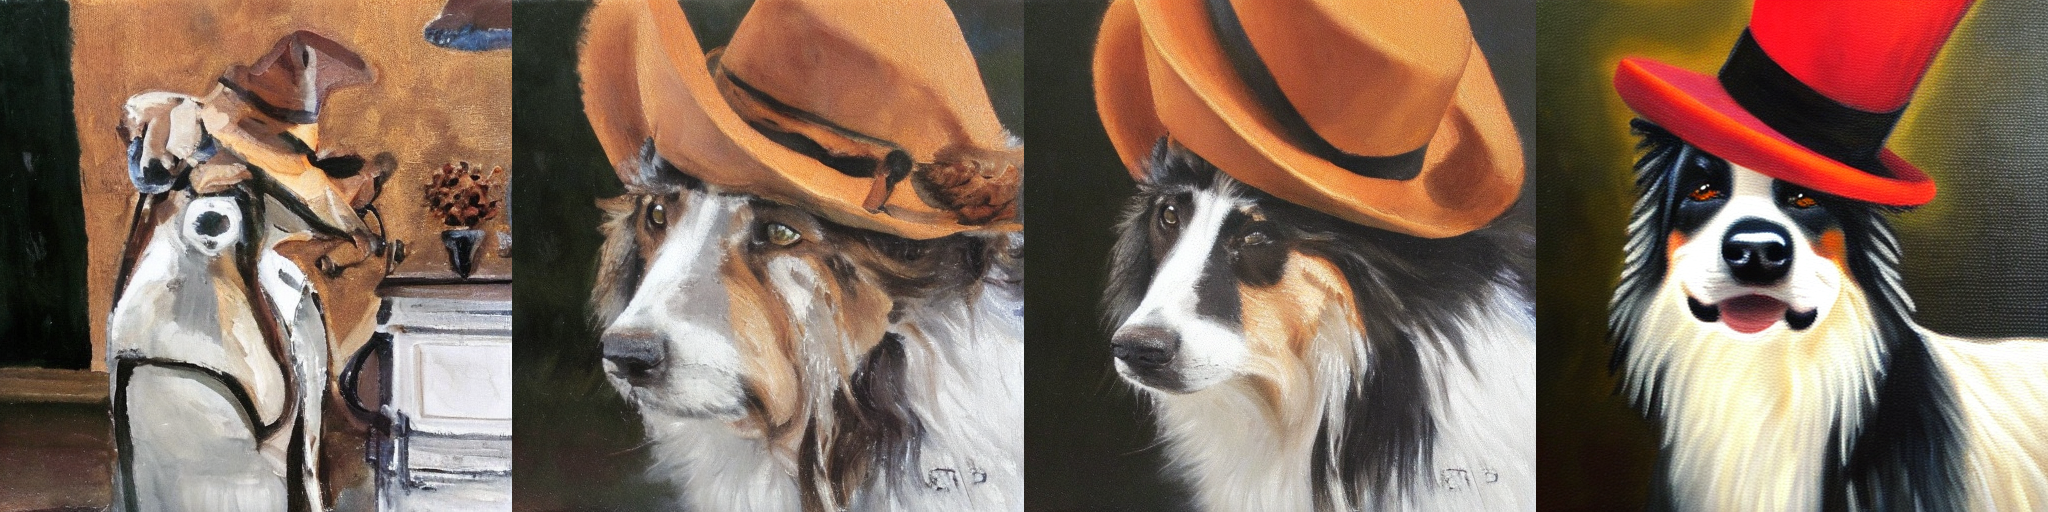

In [20]:
from utils.utils import image_grid

image_grid(images, 1, 4)

<Axes: >

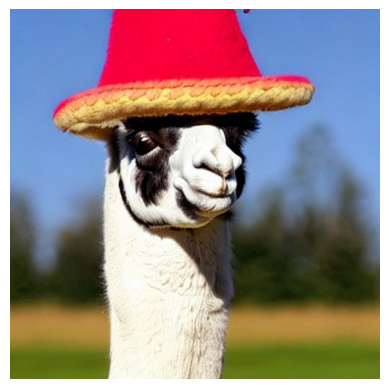

In [21]:
from utils.utils import load_image, show_image

im = load_image(
    "https://huggingface.co/datasets/genaibook/images/resolve/main/llama.jpeg",
    size=(512, 512),
)
show_image(im)

In [22]:
with torch.no_grad():
    tensor_im = transforms.ToTensor()(im).unsqueeze(0).to(device) * 2 - 1
    latent = vae.encode(tensor_im.half())  # Encode the image to a distribution
    latents = latent.latent_dist.sample()  # Sampling from the distribution
    # This scaling factor was introduced by the SD authors to reduce the
    # variance of the latents. Can be accessed via vae.config.scaling_factor
    latents = latents * 0.18215

latents.shape

torch.Size([1, 4, 64, 64])

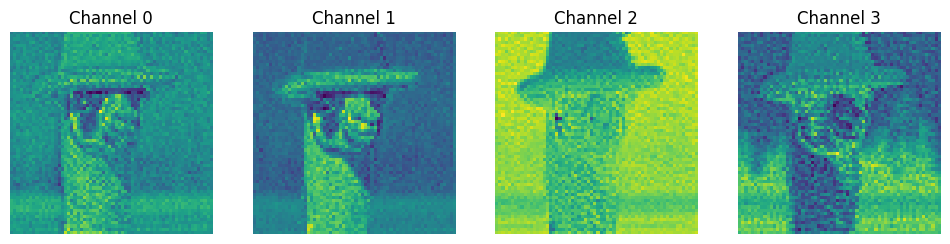

In [23]:
# Plot the individual channels of the latent representation
show_images(
    [l for l in latents[0]],
    titles=[f"Channel {i}" for i in range(latents.shape[1])],
    ncols=4,
)

<Axes: >

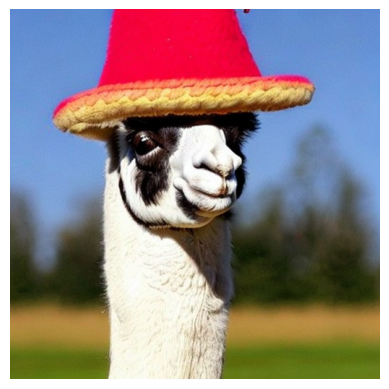

In [24]:
with torch.no_grad():
    image = vae.decode(latents / 0.18215).sample
image = (image / 2 + 0.5).clamp(0, 1)
show_image(image[0].float())

In [25]:
# Some settings
prompt = [
    "Acrylic palette knife painting of a flower"
]  # What we want to generate
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 30  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
seed = 42  # Seed for random number generator

In [26]:
# Tokenize the input
text_input = pipe.tokenizer(
    prompt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

# Do the same for the unconditional input (a blank string)
uncond_input = pipe.tokenizer(
    "",
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    return_tensors="pt",
)

# Feed both embeddings through the text encoder
with torch.no_grad():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

# Concatenate the two sets of text embeddings embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [27]:
# Prepare the Scheduler
pipe.scheduler.set_timesteps(num_inference_steps)

# Prepare the random starting latents
latents = (
    torch.randn(
        (1, pipe.unet.config.in_channels, height // 8, width // 8),
    )
    .to(device)
    .half()
)
latents = latents * pipe.scheduler.init_noise_sigma

In [28]:
for i, t in enumerate(pipe.scheduler.timesteps):
    # Create two copies of the latents to match the two text embeddings (unconditional and conditional)
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual for both sets of inputs
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample

    # Split the prediction into unconditional and conditional versions:
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    # Perform classifier-free guidance
    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample


<Axes: >

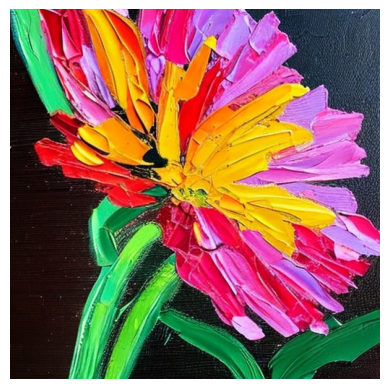

In [29]:
# Scale and decode the image latents with the VAE
latents = 1 / vae.config.scaling_factor * latents
with torch.no_grad():
    image = vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)

show_image(image[0].float())

In [30]:
import gradio as gr


def greet(name):
    return "Hello " + name


demo = gr.Interface(fn=greet, inputs="text", outputs="text")

demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
